# TP3:Méthodes d’une calcul d’une VaR dynamique (basé sur GARCH)

Ce TP est une continuité du TP-1 et du TP-2 dans lequel on souhaitait
implémenter la VaR (Value at Risk) et l’ES (Expected Shortfall) en
utilisant les méthodes classiques proposées dans la réglementation
bâloise, i.e. la méthode historique, paramétrique et bootstrap (TP1).
Cependant, une limite de ces méthodes est qu’elles ne prennent pas en
compte la queue de distribution de la perte. Pour remédier à cela, nous
avons utilisé des méthodes avec la théorie des valeurs extrêmes,
i.e. l’approche Block Maxima et l’approche Peaks Over Threshold (TP2).
Jusqu’à maintenant, on considérait que la série est iid. Cependant, dans
la réalité, les séries financières sont souvent caractérisées par une
dépendance temporelle et une volatilité conditionnelle.

Dans le cadre du TP3, il s’agira de prendre en compte la dépendance
temporelle et la volatilité conditionnelle dans les séries temporelles
financières. Pour ce faire, nous utiliserons un modèle de VAR dynamique
avec le modèle GARCH.

Le modèle GARCH (Generalized Autoregressive Conditional
Heteroskedasticity) est un modèle de volatilité conditionnelle qui
permet de modéliser la volatilité des rendements financiers. Il a été
introduit par Bollerslev en 1986. Le modèle GARCH est une extension du
modèle ARCH (Autoregressive Conditional Heteroskedasticity) introduit
par Engle en 1982. Le modèle GARCH est défini par les équations
suivantes:

$$
r_t = \mu_t + \epsilon_t
$$

$$
\epsilon_t = \sigma_t z_t
$$

$$
\sigma_t^2 = \omega + \sum \alpha_i \epsilon_{t-i}^2 + \sum \beta_i \sigma_{t-i}^2
$$

Dans ce modèle $\mu_t$ est un paramètre de tendance moyenne à
identifier, $\epsilon_t$ est le résidu, $\sigma_t^2$ est la variance
conditionnelle, $z_t$ est un bruit blanc, $\omega$ est un paramètre de
constante, $\alpha_i$ et $\beta_i$ sont les paramètres du modèle GARCH à
identifier.

In [1]:
# Définition des librairies
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

/Users/cherylkouadio/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020


In [2]:
# Import des données du CAC 40
data = yf.download("^FCHI")

# Calcul des rendements logarithmiques
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))

# Retirer la première ligne
data = data.dropna()

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

In [3]:
train = data[['log_return',"Close"]]['15-10-2008':'26-07-2022']
data_train = train['log_return']

test = data[['log_return',"Close"]]['27-07-2022':'11-06-2024']
data_test = test['log_return']

## I. Implémentation de la VaR dynamique

### I.1. Pertinence du modèle AR(1)-GARCH(1,1)

Le modèle AR(1)-GARCH(1,1) est le modèle qui, en pratique, est utilisé
pour réaliser la VaR dynamique. Cependant, il n’est pas tout le temps
adapté aux données financières. Dans ce TP, nous allons commencer par
tester l’éligibilité de ce modèle dans le cadre des données que nous
possédons.

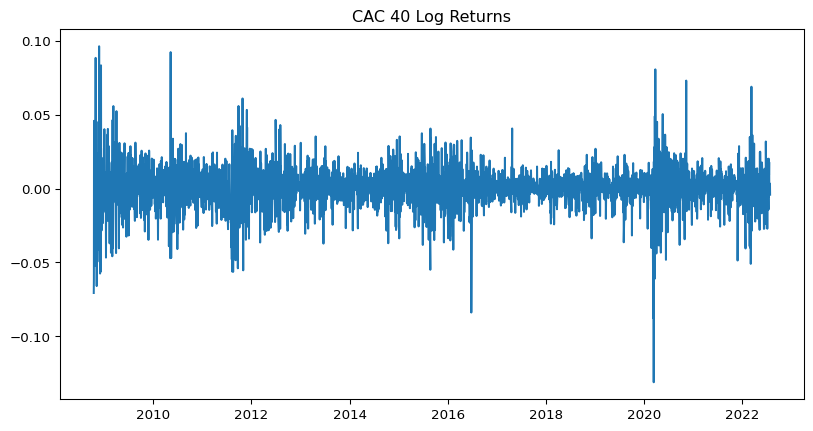

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(data_train, label='Train')
plt.title('CAC 40 Log Returns')
plt.show()

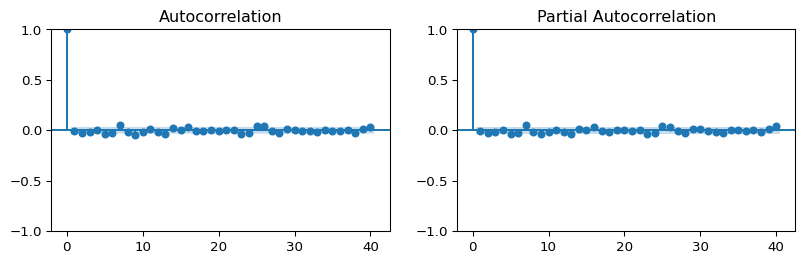

In [5]:
## ACF et PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plt.subplot(221)
plot_acf(data_train, ax=plt.gca(), lags=40)
plt.subplot(222)
plot_pacf(data_train, ax=plt.gca(), lags=40)
plt.show()

Dans la série temporelle que nous possédons, nous constatons que la
série peut être modéliser par un AR(1). Pour un test plus rigoureux de
cette hypothèse, nous allons utiliser la méthode de Lljung Box afin de
déterminer le meilleur modèle qui puisse modéliser la série. Ainsi, pour
un ordre pmax = 2 et qmax=2, nous allons : 1. Estimer les paramètres du
modèle ARMA(p,q) pour chaque combinaison de p et q 2. Calculer la
statistique de Ljung Box pour chaque combinaison de p et q afin
d’examiner si les résidus d’un modèle sont du bruit blanc 3. Filtrer les
modèles pour lesquels les résidus sont du bruit blanc 4. Choisir le
meilleur modèle en utilisant le critère d’Akaike

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox

# Paramètres du modèle
p_max = 2
q_max = 2
best_aic = np.inf
best_order = (0, 0, 0)

# Chargement de la série temporelle (remplacer par la vraie série data_unindex)
# Exemple fictif avec des données aléatoires
np.random.seed(42)
data_unindex = data_train.copy()
data_unindex.reset_index(drop=True, inplace=True)

# Création de la matrice pour stocker les AIC
aic_matrix = pd.DataFrame(np.nan, index=[f"p={p}" for p in range(p_max+1)], 
                          columns=[f"q={q}" for q in range(q_max+1)])

bb_test = pd.DataFrame(0, index=[f"p={p}" for p in range(p_max+1)], 
                          columns=[f"q={q}" for q in range(q_max+1)])

# Boucle pour estimer les modèles et stocker les AIC
for p in range(p_max + 1):
    for q in range(q_max + 1):
        try:
            model = ARIMA(data_unindex, order=(p, 0, q))
            out = model.fit()
            aic_matrix.loc[f"p={p}", f"q={q}"] = out.aic  # Stockage de l'AIC
            
            # Test de la blancheur des résidus
            ljung_box_result = acorr_ljungbox(out.resid, lags=[1], return_df=True)
            p_value = ljung_box_result['lb_pvalue'].iloc[0]

            if p_value > 0.05:
                bb_test.loc[f"p={p}", f"q={q}"] = 1
            
            # Mise à jour du meilleur modèle
            if out.aic < best_aic :
                best_aic = out.aic
                best_order = (p, 0, q)
                
        except Exception as e:
            print(f"Erreur avec (p={p}, q={q}): {e}")

print(f"Meilleur modèle ARIMA: {best_order} avec AIC={best_aic}")

print("="*30)
print("Matrice des AIC:")
print(aic_matrix)
print("="*30)
print("Matrice des test de Lljung box (1 lorsque résidus non autocorrélés):")
print(bb_test)

Meilleur modèle ARIMA: (0, 0, 0) avec AIC=-20100.176479566246
Matrice des AIC:
              q=0           q=1           q=2
p=0 -20100.176480 -20098.205891 -20097.679059
p=1 -20098.227385 -20099.862840 -20097.046957
p=2 -20097.887027 -20098.545030 -20094.033191
Matrice des test de Lljung box (1 lorsque résidus non autocorrélés):
     q=0  q=1  q=2
p=0    1    1    1
p=1    1    1    1
p=2    1    1    1

In [7]:
p = 1
q = 0

AR1 = ARIMA(data_unindex, order=(p, 0, q))
print(AR1.fit().summary())

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 3523
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10052.114
Date:                Mon, 10 Mar 2025   AIC                         -20098.227
Time:                        22:57:52   BIC                         -20079.726
Sample:                             0   HQIC                        -20091.627
                               - 3523                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.621      0.535      -0.000       0.001
ar.L1         -0.0037      0.012     -0.321      0.748      -0.027       0.019
sigma2         0.0002   2.16e-06     89.947      0.0

En utilisant la méthode énoncée plus haut, nous constatons que le modèle
ARMA(0,0) est le meilleur modèle. En effet, c’est le modèle avec le
critère d’Akaike le plus faible. Cela porte à croire que la tendance
moyenne de la série est constante. Nous allons tout de même utiliser un
modèle AR(1) pour la modéliser. En effet, c’est le deuxième modèle avec
un AIC faible.

Dans la série des résidus, nous constatons des clusters de volatilité ce
qui est signe d’une volatilité conditionnelle, et donc de la présence
d’un GARCH. De plus, dans la série des résidus du log-rendement, nous
constatons une faible autocorrélation, ce qui les fait ressembler à du
bruit blanc. Toutefois, lorsque l’on examine ces résidus au carré, la
série temporelle présente généralement une forte autocorrélation, mise
en évidence par la présence de grappes de volatilité. Cela suggère que
les rendements représentent un processus hétéroscédastique, ce qui rend
le modèle GARCH particulièrement pertinent dans le cadre de notre étude.

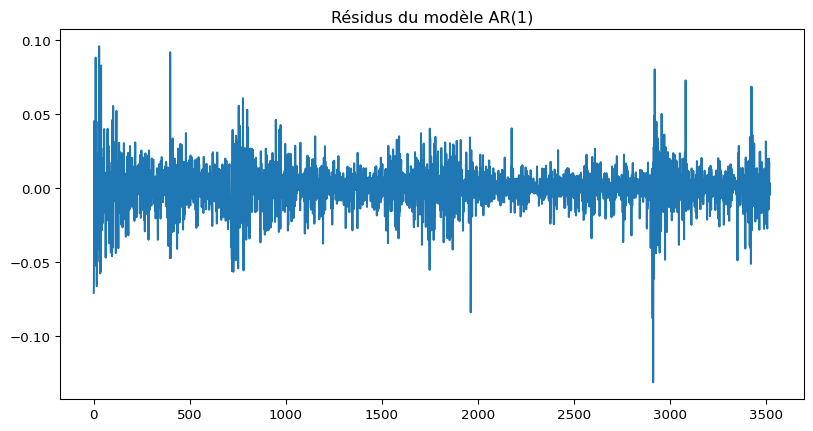

In [8]:
AR1_resid = AR1.fit().resid
plt.figure(figsize=(10, 5))
plt.plot(AR1_resid)
plt.title("Résidus du modèle AR(1)")
plt.show()

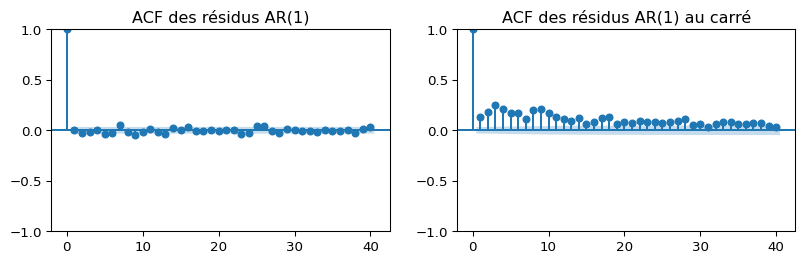

In [9]:
plt.figure(figsize=(10, 6))
plt.subplot(221)
plot_acf(AR1_resid, lags=40, ax=plt.gca())
plt.title("ACF des résidus AR(1)")
plt.subplot(222)
plot_acf(AR1_resid**2, lags=40, ax=plt.gca())
plt.title("ACF des résidus AR(1) au carré")
plt.show()

Motivés par les commentaires de (Franke, Härdle et Hafner 2004)
suggérant que, dans les applications pratiques, les modèles GARCH avec
des ordres plus petits décrivent souvent suffisamment les données et que
dans la plupart des cas GARCH(1,1) est adéquat, nous avons considéré
quatre combinaisons différentes de p=0, 1 et q=1, 2 pour chaque période
afin d’entraîner le modèle GARCH, en supposant que les résidus
standardisés suivent une distribution normale.

In [10]:
import numpy as np
import pandas as pd
from arch import arch_model

def find_garch(p_min, p_max, q_min, q_max, data, dist="normal"):
    """
    Trouve le meilleur modèle GARCH(p, q) en minimisant l'AIC.

    Paramètres :
    - p_min, p_max : Bornes pour p (ordre de l'AR dans la variance)
    - q_min, q_max : Bornes pour q (ordre de MA dans la variance)
    - data : Série temporelle utilisée pour l'estimation
    - dist : Distribution des erreurs ("normal", "t", "ged", etc.)

    Retour :
    - DataFrame contenant les valeurs de AIC pour chaque combinaison (p, q)
    - Meilleur modèle GARCH trouvé en fonction du critère AIC
    """
    
    best_aic = np.inf
    best_order = (0, 0, 0)
    
    results = []

    for p in range(p_min, p_max + 1):
        for q in range(q_min, q_max + 1):
            try:
                # Spécification du modèle GARCH(p, q)
                garch_spec = arch_model(data, vol='Garch', p=p, q=q, mean='Zero', dist=dist)
                out = garch_spec.fit(disp="off")
                
                # Calcul de l'AIC
                current_aic = out.aic * len(data)

                # Mettre à jour le meilleur modèle si un plus petit AIC est trouvé
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order = (p, 0, q)
                
                # Ajouter les résultats dans la liste
                results.append({'p': p, 'q': q, 'aic': current_aic, 'relative_gap': np.nan})
            
            except Exception as e:
                print(f"Erreur pour (p={p}, q={q}): {e}")
                continue
    
    # Convertir en DataFrame
    results_df = pd.DataFrame(results)

    # Calculer l'écart relatif par rapport au meilleur AIC
    results_df['relative_gap'] = (results_df['aic'] - best_aic) * 100 / best_aic
    
    return results_df, best_order

results_df, best_garch_order = find_garch(p_min=1, p_max=2, q_min=0, q_max=2, data=data_unindex, dist="normal")

print(f"Meilleur modèle GARCH: {best_garch_order} avec AIC={best_aic}")
print("="*30)
print("Résultats pour les modèles testés:")
results_df.sort_values(by='relative_gap', ascending=False)

Meilleur modèle GARCH: (1, 0, 1) avec AIC=-20100.176479566246
Résultats pour les modèles testés:

En utilisant le critère AIC pour sélectionner le meilleur modèle, nous
avons conclu que GARCH(1,1) est effectivement le meilleur modèle.

In [11]:
garch11 = arch_model(data_unindex, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
print("="*78)
print("Résumé du modèle GARCH(1,1)")
print("="*78)
print(garch11.fit(disp="off").summary())

Résumé du modèle GARCH(1,1)
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10638.0
Distribution:                  Normal   AIC:                          -21270.1
Method:            Maximum Likelihood   BIC:                          -21251.6
                                        No. Observations:                 3523
Date:                Mon, Mar 10 2025   Df Residuals:                     3523
Time:                        22:57:53   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.8930e-06  4.514e-

In [12]:
cond_resid =garch11.fit(disp="off").conditional_volatility # Volatilité conditionnelle => sigma_t
resid = garch11.fit(disp="off").resid # résidus du modèle => eps_t
resid_std = garch11.fit(disp="off").std_resid  # résidus studentisés => eta_t

# jarque bera test

from scipy.stats import jarque_bera

jb_test = jarque_bera(resid_std)
print("H0: Les résidus studentisés suivent une loi normale")
print(f"Test de Jarque-Bera sur les résidus studentisés: JB={jb_test[0]}, p-value={jb_test[1]}")
# reject the null hypothesis of normality for the distribution of the residuals, 
# as a rule of thumb, which implies that the data to be fitted is not
# normally distributed

H0: Les résidus studentisés suivent une loi normale
Test de Jarque-Bera sur les résidus studentisés: JB=848.8557767883675, p-value=4.71313744144075e-185

In [13]:
### y revenir

### coeff <1

In [14]:
# Test d'homoscédasticité
# Ljung-Box test sur résidus
lb_test_resid = acorr_ljungbox(resid_std, lags=[i for i in range(1, 13)], return_df=True)
print("Ljung-Box Test sur résidus:\n", lb_test_resid)

# Ljung-Box test sur carrés des résidus
lb_test_resid_sq = acorr_ljungbox(resid_std**2, lags=[i for i in range(1, 13)], return_df=True)
print("Ljung-Box Test sur carrés des résidus:\n", lb_test_resid_sq)

Ljung-Box Test sur résidus:
      lb_stat  lb_pvalue
1   0.028087   0.866904
2   0.572026   0.751253
3   0.690100   0.875530
4   1.235029   0.872298
5   2.199461   0.820914
6   2.491801   0.869384
7   2.828137   0.900433
8   2.941010   0.938005
9   3.793237   0.924486
10  4.644433   0.913631
11  4.727144   0.943657
12  6.763448   0.872842
Ljung-Box Test sur carrés des résidus:
       lb_stat  lb_pvalue
1    0.280711   0.596235
2    0.339634   0.843819
3    6.670837   0.083163
4    7.395445   0.116409
5    8.091586   0.151260
6    8.233789   0.221471
7    8.724987   0.273009
8    9.386238   0.310768
9    9.938908   0.355454
10  11.579309   0.314198
11  13.394501   0.268325
12  13.845698   0.310670

In [15]:
# LM test pour les effets ARCH
from statsmodels.stats.diagnostic import het_arch

lm_test = het_arch(resid_std)
print('LM Test Statistique: %.3f, p-value: %.3f' % (lm_test[0], lm_test[1]))

LM Test Statistique: 12.218, p-value: 0.271

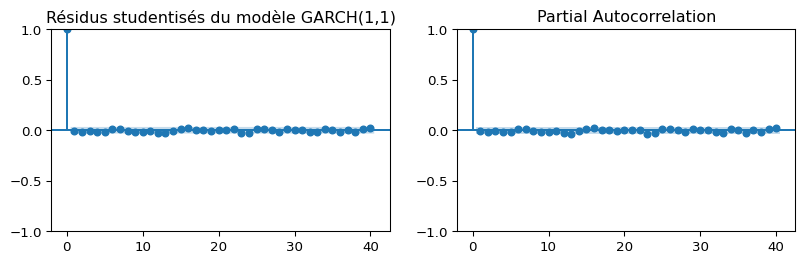

In [16]:
plt.figure(figsize=(10, 6))
plt.subplot(221)
plot_acf(resid_std, lags=40, ax=plt.gca())
plt.title("ACF des résidus studentisés")
plt.title("Résidus studentisés du modèle GARCH(1,1)")
plt.subplot(222)
plot_pacf(resid_std, lags=40, ax=plt.gca())
plt.show()

Le modèle AR(1)-GARCH(1,1) estimé est le suivant :

$$
r_t = \mu_t + \epsilon_t
$$

où $\mu_t = 0.0001 - 0.0037 r_{t-1}$

$$
\epsilon_t = \sigma_t \eta_t
$$

$$
\sigma_t^2 = 3.89 \times 10^{-6} + 0.10 \times \epsilon_{t-i}^2 + 0.88 \times \sigma_{t-i}^2
$$

avec $\eta_t$ un bruit blanc supposée gaussien.

Dans ce cas, nous rencontrons des problèmes au niveau de la
significativité du coefficient AR(1). En effet, il aurait été plus
judicieux de ne pas modéliser la tendance moyenne du rendement et la
supposer constante. De plus, au niveau du GARCH(1,1), les résidus sont
bien des bruits blancs homoscédastiques (test de lljung box et test LM).
Cependant, nous avons supposé que $\eta_t$ est un bruit blanc gaussien.
Cela n’est pas vérifié. Il aurait été judicieux de tester d’autres
distributions telles que Students’s t (’t’, ‘studentst’), Skewed
Student’s t (‘skewstudent’, ‘skewt’) ou encore Generalized Error
Distribution (GED).

    **Test de Lagrange Multiplier (LM) pour l'effet ARCH**

    Le test de Lagrange Multiplier (LM) pour l'effet ARCH est un outil statistique qui vérifie la présence d'effets ARCH (AutoRegressive Conditional Heteroskedasticity) dans une série temporelle.

    L'effet ARCH se manifeste lorsque la variance d'une erreur est une fonction de ses erreurs passées. Cette propriété est courante dans les séries temporelles financières, où de grandes variations des rendements sont souvent suivies par de grandes variations et vice versa.

    Le test de LM vérifie l'hypothèse nulle que les erreurs sont homoscédastiques (variance constante). Si la p-value du test est inférieure à un seuil prédéfini (généralement 0,05), l'hypothèse nulle est rejetée, indiquant la présence d'effets ARCH.

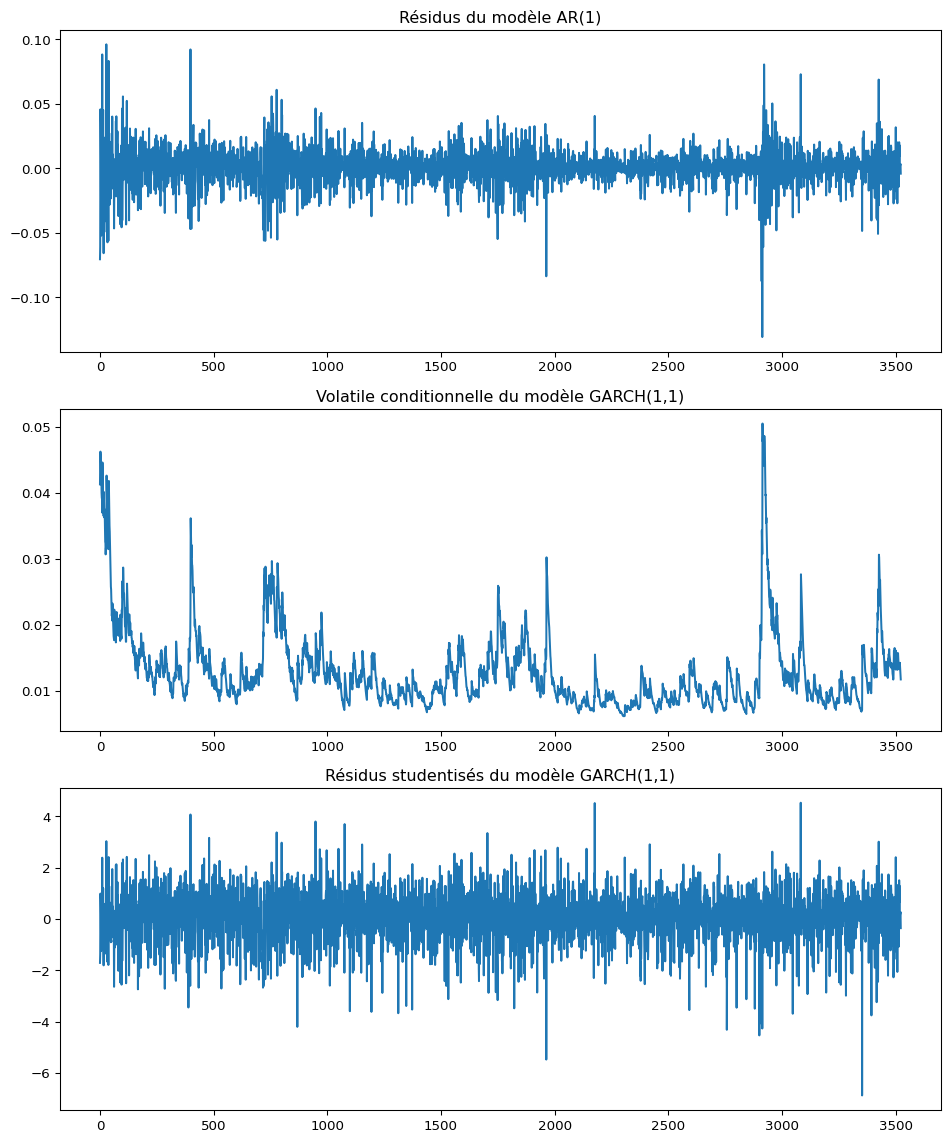

In [17]:
# Création de la figure avec des sous-graphiques alignés verticalement
plt.figure(figsize=(10, 12))

# Premier graphique : CAC 40
plt.subplot(311)
plt.plot(resid) 
plt.title("Résidus du modèle AR(1)")

# Deuxième graphique : Résidus du modèle AR(1)
plt.subplot(312)
plt.plot(cond_resid)
plt.title("Volatile conditionnelle du modèle GARCH(1,1)")

# Troisième graphique : Résidus studentisés du modèle GARCH(1,1)
plt.subplot(313)
plt.plot(resid_std, label='Résidus studentisés du modèle GARCH(1,1)')
plt.title("Résidus studentisés du modèle GARCH(1,1)")

# Affichage des graphiques
plt.tight_layout()
plt.show()

### I.2. Dynamique historique de $\mu_t$ et $\sigma_t$

$$
r_t = \mu_t + \sigma_t \times \epsilon_t
\quad
\text{avec} \quad
\begin{cases}
    \mu_t = \mu + \varphi r_{t-1} \\
    \sigma_t^2 = \omega + a (r_{t-1} - \mu_{t-1})^2 + b \sigma_{t-1}^2
\end{cases}
$$

Pour avoir la dynamique historique de $\mu_t$ et $\sigma_t$, nous allons
utiliser les données historiques de la série temporelle ainsi que les
estimations des paramètres $\Theta = (\mu, \varphi, \omega, a, b)$ du
modèle AR(1)-GARCH(1,1) que nous avons estimé précédemment par maximum
de vraisemblance.

Pour $t=1$, nous allons initialiser $\mu_1$ par la moyenne $\hat{\mu}$
et $\sigma_1$ par la variance à long terme $\frac{\omega}{1 - a - b}$.

In [18]:
print(AR1.fit().summary())

# tester arima avec arch_model ou arch
mu = AR1.fit().params[0]
print(f"Paramètre mu: {mu}")
phi = AR1.fit().params[1]
print(f"Paramètre phi: {phi}")

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 3523
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10052.114
Date:                Mon, 10 Mar 2025   AIC                         -20098.227
Time:                        22:57:53   BIC                         -20079.726
Sample:                             0   HQIC                        -20091.627
                               - 3523                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.621      0.535      -0.000       0.001
ar.L1         -0.0037      0.012     -0.321      0.748      -0.027       0.019
sigma2         0.0002   2.16e-06     89.947      0.0

In [19]:
print(garch11.fit(disp="off").summary())
omega = garch11.fit(disp="off").params[0]
print(f"Paramètre omega: {omega}")
a = garch11.fit(disp="off").params[1]
print(f"Paramètre alpha: {a}")
b = garch11.fit(disp="off").params[2]
print(f"Paramètre beta: {b}")

                       Zero Mean - GARCH Model Results                        
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10638.0
Distribution:                  Normal   AIC:                          -21270.1
Method:            Maximum Likelihood   BIC:                          -21251.6
                                        No. Observations:                 3523
Date:                Mon, Mar 10 2025   Df Residuals:                     3523
Time:                        22:57:53   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.8930e-06  4.514e-10   8624.704      0.000 [3.

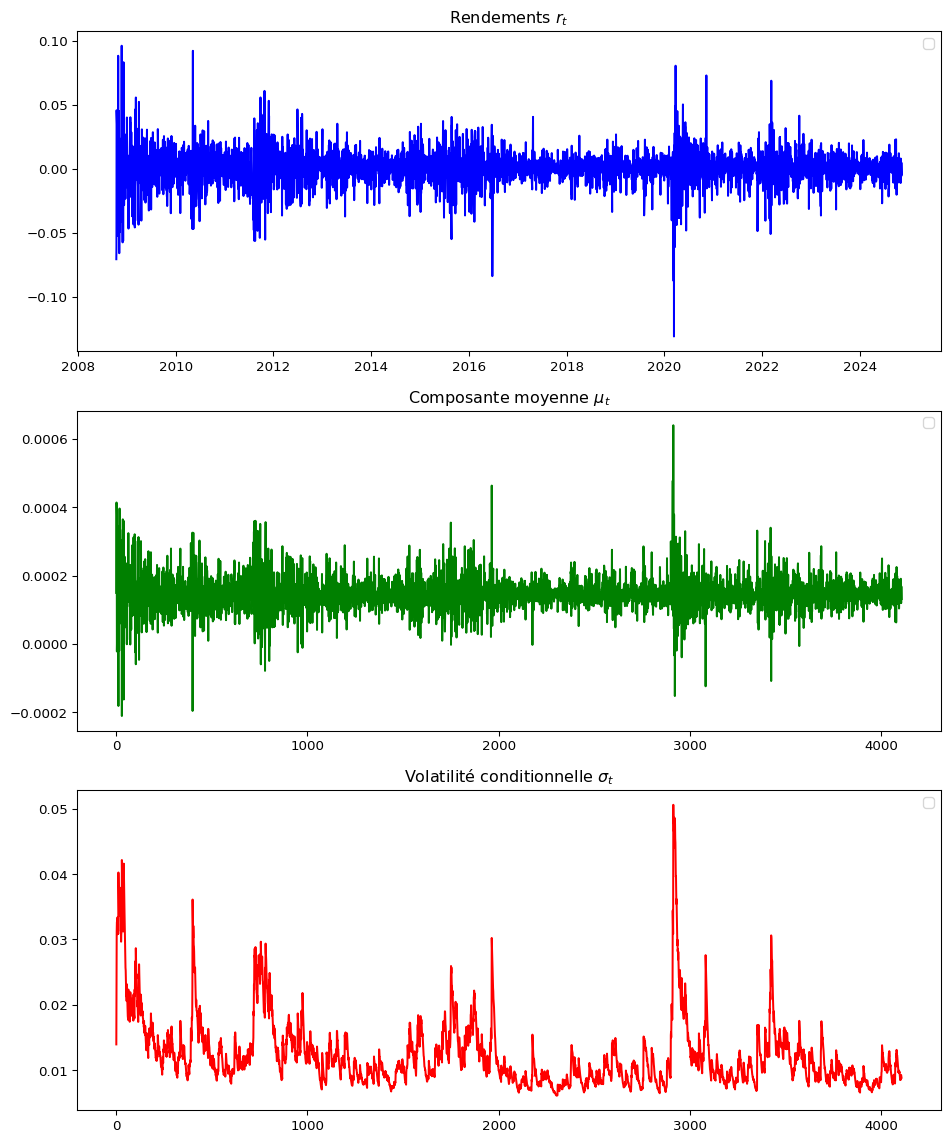

In [20]:
T_train = len(data_train)
T_test = len(data_test)

T = T_train + T_test

# Initialisation des séries
r = pd.concat([data_train, data_test], axis=0)
mu_t = np.zeros(T)    # Composante moyenne
sigma2 = np.zeros(T)  # Variance conditionnelle

# Conditions initiales
mu_t[0] = mu
sigma2[0] = omega / (1 - a - b)  # Variance de long terme

# Simulation du modèle
for t in range(1, T):
    mu_t[t] = mu + phi * r[t-1]  # Partie moyenne
    sigma2[t] = omega + a * (r[t-1] - mu_t[t-1])**2 + b * sigma2[t-1]  # Variance conditionnelle

# Affichage des résultats
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].plot(r, color="blue")
ax[0].set_title("Rendements $r_t$")
ax[0].legend()

ax[1].plot(mu_t, color="green")
ax[1].set_title("Composante moyenne $\mu_t$")
ax[1].legend()

ax[2].plot(np.sqrt(sigma2), color="red")
ax[2].set_title("Volatilité conditionnelle $\sigma_t$")
ax[2].legend()

plt.tight_layout()
plt.show()

En analysant la dynamique de $\mu_t$, nous constatons que la tendance
moyenne est très semblable à la série des log-rendements. Cela est dû au
fait que le modèle AR(1) n’est pas pertinent pour modéliser la série. En
effet, la série des log-rendements ressemble déjà à un bruit blanc. Par
ailleurs, nous observons de fortes périodes de volatilité dans la série
des log-rendements pendant les périodes de crises, i.e. 2008-2009 qui
correspond à la crise des subprimes et 2020 qui correspond à la crise du
Covid-19. Le modèle GARCH semble bien capturer ces périodes de
volatilité dans la volatilité conditionnelle calibrée.

### I.3. Estimation de la VaR

In [21]:
# VaR historique

def historical_var(data, alpha=0.99):
    """
    Calcul de la VaR historique
    data : les rendements logarithmiques
    alpha : le niveau de confiance
    """
    return -np.percentile(data, 100*(1 - alpha))

# VaR gaussienne

def gaussian_var(data, alpha):
    """
    Calcul de la VaR gaussienne
    data : les rendements logarithmiques
    alpha : le niveau de confiance
    """
    from scipy.stats import norm

    mu = np.mean(data)
    sigma = np.std(data)
    return -(mu + sigma * norm.ppf(1 - alpha))

# Loi de Skew Student par maximum de vraisemblance.

from scipy.optimize import minimize
from scipy.stats import t


def skew_student_pdf(x, mu, sigma, gamma, nu ):
    """
    Compute the Skew Student-t probability density function (PDF).
    """
    

    t_x = ((x - mu) * gamma / sigma) * np.sqrt((nu + 1) / (nu + ((x - mu) / sigma) ** 2))
    # PDF of the standard Student-t distribution
    pdf_t = t.pdf(x , df=nu,  loc=mu, scale=sigma)
    # CDF of the transformed Student-t distribution
    cdf_t = t.cdf(t_x, df=nu + 1,loc=0, scale=1)

    # Skew Student density function
    density = 2 * pdf_t * cdf_t

    return density


def skew_student_log_likelihood(params, data):
    """
    Calcul de la log-vraisemblance de la loi de Skew Student
    params [mu, sigma, gamma, nu]: les paramètres de la loi
    data : les rendements logarithmiques
    """
    mu, sigma, gamma, nu = params
    density = skew_student_pdf(data , mu, sigma, gamma, nu)
    # log-vraisemblance
    loglik = np.sum(np.log(density))
    
    return - loglik

# Optimisation des paramètres avec contraintes de positivité sur sigma et nu
def skew_student_fit(data):
    """
    Estimation des paramètres de la loi de Skew Student
    """
    # initial guess
    x0 = np.array([np.mean(data), np.std(data), 1, 4])

    # contraintes
    bounds = [(None, None), (0, None), (None, None), (None, None)]

    # optimisation
    res = minimize(skew_student_log_likelihood, x0, args=(data), bounds=bounds)

    return res.x

params = skew_student_fit(resid_std)
print("="*80)
print("Les paramètres estimés de la loi de Skew Student sont : ")
print("-"*15)
print("Mu : ", params[0])
print("Sigma : ", params[1])
print("Gamma : ", params[2])
print("Nu : ", params[3])
print("="*80)


params_sstd = {
    "mu" : params[0], 
    "sigma" : params[1],
    "gamma" : params[2],
    "nu" : params[3]
}


## Intégration de la fonction de densité
from scipy import integrate
from scipy.optimize import minimize_scalar

def integrale_SkewStudent(x,params):
    borne_inf = -np.inf
    resultat_integration, erreur = integrate.quad(lambda x: skew_student_pdf(x, **params), borne_inf, x)
    return resultat_integration

def fonc_minimize(x, alpha,params):
    value = integrale_SkewStudent(x,params)-alpha
    return abs(value)

def skew_student_quantile(alpha,mu, sigma, gamma, nu ):
    params = {
    "mu" : mu ,
    "sigma" : sigma,
    "gamma" : gamma,
    "nu" : nu
    }

    if alpha <0 or alpha >1:
        raise Exception("Veuillez entrer un niveau alpha entre 0 et 1")
    else:
        resultat_minimisation = minimize_scalar(lambda x: fonc_minimize(x, alpha,params))
        return resultat_minimisation.x
    
# Objectif : écrire une fonction qui calcule la VaR skew-student

def sstd_var(alpha, params):
    """
    Calcul de la VaR skew student
    data : les rendements logarithmiques
    alpha : le niveau de confiance
    """

    return -skew_student_quantile(1-alpha, **params)


#### A FAIRE VAR POT et BM

from scipy.stats import genextreme as gev

import numpy as np
import pandas as pd
neg_resid = -resid_std

def get_extremes(returns, block_size, min_last_block=0.6):
    """
    Extrait les valeurs extrêmes d'une série de rendements par blocs.
    
    Arguments :
    returns : pandas Series (index = dates, valeurs = rendements)
    block_size : int, taille du bloc en nombre de jours
    min_last_block : float, proportion minimale pour inclure le dernier bloc incomplet
    
    Retourne :
    maxima_sample : liste des valeurs maximales par bloc
    maxima_dates : liste des dates associées aux valeurs maximales
    """
    n = len(returns)
    num_blocks = n // block_size

    maxima_sample = []
    maxima_dates = []

    for i in range(num_blocks):
        block_start = i * block_size
        block_end = (i + 1) * block_size
        block_data = returns.iloc[block_start:block_end]  # Sélectionner le bloc avec les index

        max_value = block_data.max()
        max_date = block_data.idxmax()  # Récupérer l'index de la valeur max

        maxima_sample.append(max_value)
        maxima_dates.append(max_date)

    # Gestion du dernier bloc s'il reste des données suffisantes
    block_start = num_blocks * block_size
    block_data = returns.iloc[block_start:]

    if len(block_data) >= min_last_block * block_size:
        max_value = block_data.max()
        max_date = block_data.idxmax()
        
        maxima_sample.append(max_value)
        maxima_dates.append(max_date)
        
    return pd.Series(maxima_sample, index=maxima_dates)  # Retourner une Series avec les dates comme index



def BM_var(alpha,s,shape,loc,scale):
    """
    Calcul de la VaR gaussienne
    alpha : le niveau de confiance de la VaR
    s : le nombre de jours dans un bloc
    """
    alpha_bm = 1-s*(1-alpha)

    return gev.ppf(alpha_bm, shape, loc = loc, scale = scale),alpha_bm

extremes = get_extremes(neg_resid, block_size=21, min_last_block=0.6)
params_gev = gev.fit(extremes)
print("="*80)
print("Les paramètres estimés de la loi de GEV sont : ")
print("-"*15)
print(f"Shape (xi) = {params_gev[0]:.2f}")
print(f"Localisation (mu) = {params_gev[1]:.2f}")
print(f"Echelle (sigma) = {params_gev[2]:.2f}")
print("="*80)


def POT_var(data,alpha,u,shape,loc,scale):
    """
    Calcul de la VaR gaussienne
    alpha : le niveau de confiance de la VaR
    s : le nombre de jours dans un bloc
    """
    n = len(data)
    excess_values = [value - u for value in data if value >= u]
    nu = len(excess_values)

    alpha_pot = 1-n*(1-alpha)/nu

    return genpareto.ppf(alpha_pot, shape, loc = loc, scale = scale) + u,alpha_pot


u = 0.03
excess_values = [value - u for value in neg_resid if value >= u]

from scipy.stats import genpareto

params_gpd = genpareto.fit(excess_values)

# Afficher les paramètres estimés
print("="*80)
print("Paramètres estimés de la distribution GPD:")
print(f"Shape (xi) = {params_gpd[0]:.2f}")
print(f"Localisation (mu) = {params_gpd[1]:.2f}")
print(f"Echelle (sigma) = {params_gpd[2]:.2f}")
print("="*80)

Les paramètres estimés de la loi de Skew Student sont : 
---------------
Mu :  0.42506987856855155
Sigma :  0.8686238872541445
Gamma :  -0.6074089740677895
Nu :  5.607559653340765
Les paramètres estimés de la loi de GEV sont : 
---------------
Shape (xi) = -0.01
Localisation (mu) = 1.64
Echelle (sigma) = 0.72
Paramètres estimés de la distribution GPD:
Shape (xi) = -0.04
Localisation (mu) = 0.00
Echelle (sigma) = 0.80

In [22]:
alpha = 0.99

var_hist_train = historical_var(resid_std, alpha=alpha)
var_gauss_train = gaussian_var(resid_std, alpha=alpha)
var_sstd_train = sstd_var(alpha, params_sstd)
var_BM_train,_ = BM_var(0.99, 21, *params_gev)
var_POT_train,_ = POT_var(neg_resid, alpha, u,*params_gpd)

# in a df
var = pd.DataFrame({
    'Historique': [var_hist_train],
    'Gaussienne': [var_gauss_train],
    'Skew Student': [var_sstd_train],
    'Block Maxima': [var_BM_train],
    'Peak Over Threshold': [var_POT_train]
})

print("="*80)
print("Value at Risk sur les résidus studentisés (en %) pour h=1j")
print(round(100*var,2))
print("="*80)

Value at Risk sur les résidus studentisés (en %) pour h=1j
   Historique  Gaussienne  Skew Student  Block Maxima  Peak Over Threshold
0      264.12      229.76        280.29        268.68               284.98

#### a. VaR historique dynamique

In [23]:
var_t = np.zeros(T_test)    # Composante moyenne
nb_exp = 0
for t in range(T_test):
    var_t[t] = - (mu_t[t+T_train] + np.sqrt(sigma2[t+T_train])*var_hist_train)
    nb_exp += (r[t+T_train] < var_t[t]).astype(int)
    
var_t = pd.Series(var_t, index=data_test.index)
print(f"Nombre d'exceptions = {nb_exp} sur {T_test} jours")

Nombre d'exceptions = 4 sur 586 jours

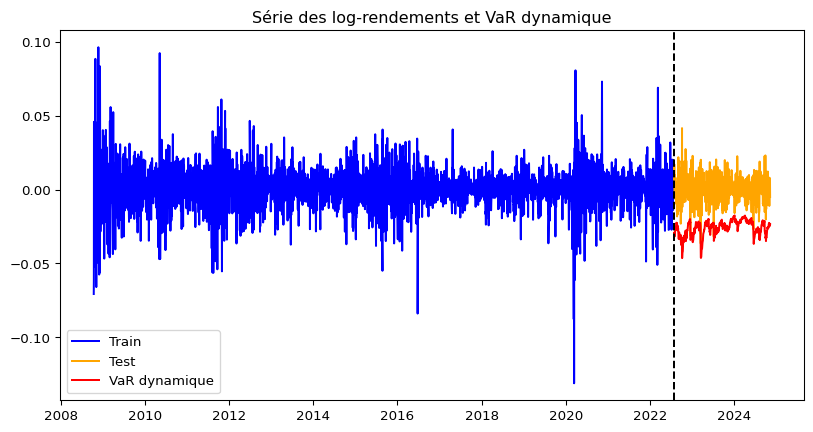

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(data_train, color="blue", label='Train')
plt.plot(data_test, color="orange", label='Test')
plt.plot(var_t, color="red",label='VaR dynamique')
plt.axvline(x=data_test.index[0], color='black', linestyle='--')
plt.legend()
plt.title('Série des log-rendements et VaR dynamique')
plt.show()

Text(0.5, 1.0, 'Zoom sur la VaR dynamique')

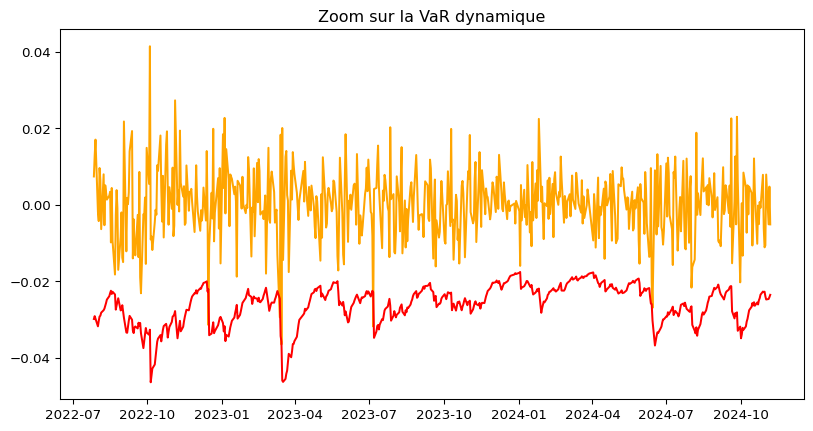

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(data_test, color="orange")
plt.plot(var_t, color="red")
plt.title('Zoom sur la VaR dynamique')

In [26]:
# backtest à faire (optionnel)